In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('ERA5_Weather_Data_Monash (1).csv')
data

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100052,2021-05-31 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,2021-05-31 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,2021-05-31 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,2021-05-31 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [2]:
from datetime import datetime
from distutils.util import strtobool
import pandas as pd

def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            line = line.strip()

            if line:
                if line.startswith("@"):  
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if len(line_content) != 3:  
                                raise Exception("Invalid meta-data specification.")
                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if len(line_content) != 2:  
                                raise Exception("Invalid meta-data specification.")
                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(strtobool(line_content[1]))
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))
                    else:
                        if len(col_names) == 0:
                            raise Exception("Missing attribute section.")
                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception("Missing attribute section.")
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []
                            for col in col_names:
                                all_data[col] = []
                        full_info = line.split(":")
                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")
                        series = full_info[len(full_info) - 1]
                        series = series.split(",")
                        if len(series) == 0:
                            raise Exception("A given series should contain comma-separated numeric values.")
                        numeric_series = []
                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))
                        if numeric_series.count(replace_missing_vals_with) == len(numeric_series):
                            raise Exception("All series values are missing.")
                        all_series.append(pd.Series(numeric_series).array)
                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(full_info[i], "%Y-%m-%d %H-%M-%S")
                            else:
                                raise Exception("Invalid attribute type.")
                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)
                line_count += 1
        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")
        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)
        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )

# Example usage
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("nov_data.tsf")
train_data = convert_tsf_to_dataframe("nov_data.tsf")

test_data = convert_tsf_to_dataframe("phase_1_data (1).tsf")
train_data


(   series_name     start_timestamp  \
 0    Building0 2016-07-03 21:30:00   
 1    Building1 2019-01-09 23:15:00   
 2    Building3 2016-03-01 04:15:00   
 3    Building4 2019-07-03 04:45:00   
 4    Building5 2019-07-25 23:00:00   
 5    Building6 2019-07-25 01:45:00   
 6       Solar0 2020-04-25 14:00:00   
 7       Solar1 2018-12-31 13:00:00   
 8       Solar2 2019-06-05 14:00:00   
 9       Solar3 2019-06-05 14:00:00   
 10      Solar4 2019-06-05 14:00:00   
 11      Solar5 2019-01-15 13:00:00   
 
                                          series_value  
 0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
 1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
 2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
 3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
 4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
 5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
 6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
 7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [3]:
dfs = pd.DataFrame(list(train_data)[0])
dfs

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
building_0=dfs['series_value'][0]
building_1=dfs['series_value'][1]
building_3=dfs['series_value'][2]
building_4=dfs['series_value'][3]
building_5=dfs['series_value'][4]
building_6=dfs['series_value'][5]

In [5]:
start_0 = dfs['start_timestamp'][0]
start_1 = dfs['start_timestamp'][1]
start_3 = dfs['start_timestamp'][2]
start_4 = dfs['start_timestamp'][3]
start_5 = dfs['start_timestamp'][4]
start_6 = dfs['start_timestamp'][5]

start_datetime_0 = pd.to_datetime(start_0)
start_datetime_1 = pd.to_datetime(start_1)
start_datetime_3 = pd.to_datetime(start_3)
start_datetime_4 = pd.to_datetime(start_4)
start_datetime_5 = pd.to_datetime(start_5)
start_datetime_6 = pd.to_datetime(start_6)

data_length_0=len(building_0) #148810
data_length_1=len(building_1) #60483
data_length_3=len(building_3) #160783
data_length_4=len(building_4) #43757
data_length_5=len(building_5) #41572
data_length_6=len(building_6) #41657

end_datetime_0 = start_datetime_0 + pd.Timedelta(minutes=15 * (data_length_0 - 1))
end_datetime_1 = start_datetime_1 + pd.Timedelta(minutes=15 * (data_length_1 - 1))
end_datetime_3 = start_datetime_3 + pd.Timedelta(minutes=15 * (data_length_3 - 1))
end_datetime_4 = start_datetime_4 + pd.Timedelta(minutes=15 * (data_length_4 - 1))
end_datetime_5 = start_datetime_5 + pd.Timedelta(minutes=15 * (data_length_5 - 1))
end_datetime_6 = start_datetime_6 + pd.Timedelta(minutes=15 * (data_length_6 - 1))

#time_series_data = {
#    'building_0': {'start_date': start_0, 'end_date': end_datetime_0, 'data': building_energy[0]},
#    'building_1': {'start_date': start_1, 'end_date': end_datetime_1, 'data': building_energy[1]},
#    'building_3': {'start_date': start_3, 'end_date': end_datetime_3, 'data': building_energy[2]},
#    'building_4': {'start_date': start_4, 'end_date': end_datetime_4, 'data': building_energy[3]},
#    'building_5': {'start_date': start_5, 'end_date': end_datetime_5, 'data': building_energy[4]},
#    'building_6': {'start_date': start_6, 'end_date': end_datetime_6, 'data': building_energy[5]}    
#}


#overall_start_date = min([pd.to_datetime(series['start_date']) for series in time_series_data.values()])
#overall_end_date = max([pd.to_datetime(series['end_date']) for series in time_series_data.values()])

time_index = pd.date_range(start='2016-03-01 04:15:00', end='2020-09-30 23:45:00', freq='15T')

#for series_name, series_info in time_series_data.items():
#    series_start_date = pd.to_datetime(series_info['start_date'])
#    series_end_date = pd.to_datetime(series_info['end_date'])
#    series_data = series_info['data']
    
    # Reindex the time series data to align with the time index and insert NaN values where necessary
#    series_index = pd.date_range(start=series_start_date, end=series_end_date, freq='15T')
#    series_values = pd.Series(series_data, index=series_index)
#    buildings_time[series_name] = series_values.reindex(time_index,fill_value=np.nan)

final_time_series = pd.DataFrame(index=time_index)# columns = ['Building0','Building1','Building3','Building4','Building5'])

In [6]:
range_0 = pd.date_range(start=start_datetime_0, end=end_datetime_0, freq='15T')
range_1 = pd.date_range(start=start_datetime_1, end=end_datetime_1, freq='15T')
range_3 = pd.date_range(start=start_datetime_3, end=end_datetime_3, freq='15T')
range_4 = pd.date_range(start=start_datetime_4, end=end_datetime_4, freq='15T')
range_5 = pd.date_range(start=start_datetime_5, end=end_datetime_5, freq='15T')
range_6 = pd.date_range(start=start_datetime_6, end=end_datetime_6, freq='15T')


In [7]:
time_series_0 = pd.DataFrame(index = range_0)
time_series_0['building 0'] = building_0

time_series_1 = pd.DataFrame(index = range_1)
time_series_1['building 1'] = building_1

time_series_3 = pd.DataFrame(index = range_3)
time_series_3['building 3'] = building_3

time_series_4 = pd.DataFrame(index = range_4)
time_series_4['building 4'] = building_4

time_series_5 = pd.DataFrame(index = range_5)
time_series_5['building 5'] = building_5

time_series_6 = pd.DataFrame(index = range_6)
time_series_6['building 6'] = building_6

final_time_series['building 0'] = time_series_0['building 0'].reindex(final_time_series.index)
final_time_series['building 1'] = time_series_1['building 1'].reindex(final_time_series.index)
final_time_series['building 3'] = time_series_3['building 3'].reindex(final_time_series.index)
final_time_series['building 4'] = time_series_4['building 4'].reindex(final_time_series.index)
final_time_series['building 5'] = time_series_5['building 5'].reindex(final_time_series.index)
final_time_series['building 6'] = time_series_6['building 6'].reindex(final_time_series.index)

In [8]:
building_0 = final_time_series['building 0']
building_1 = final_time_series['building 1']
building_3 = final_time_series['building 3']
building_4 = final_time_series['building 4']
building_5 = final_time_series['building 5']
building_6 = final_time_series['building 6']

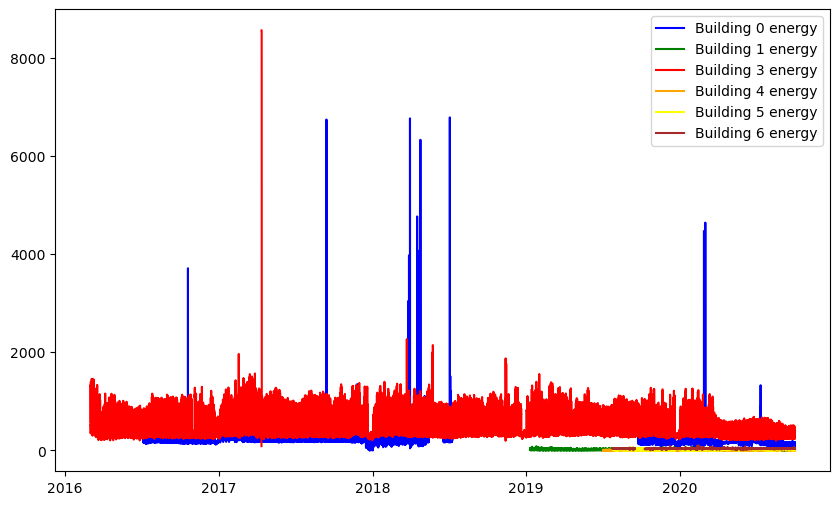

In [9]:
plt.figure(figsize = (10,6))
plt.plot(final_time_series.index, final_time_series['building 0'], label = 'Building 0 energy', color = 'blue')
plt.plot(final_time_series.index, final_time_series['building 1'], label = 'Building 1 energy', color = 'green')
plt.plot(final_time_series.index, final_time_series['building 3'], label = 'Building 3 energy', color = 'red')
plt.plot(final_time_series.index, final_time_series['building 4'], label = 'Building 4 energy', color = 'orange')
plt.plot(final_time_series.index, final_time_series['building 5'], label = 'Building 5 energy', color = 'yellow')
plt.plot(final_time_series.index, final_time_series['building 6'], label = 'Building 6 energy', color = 'brown')
plt.legend()


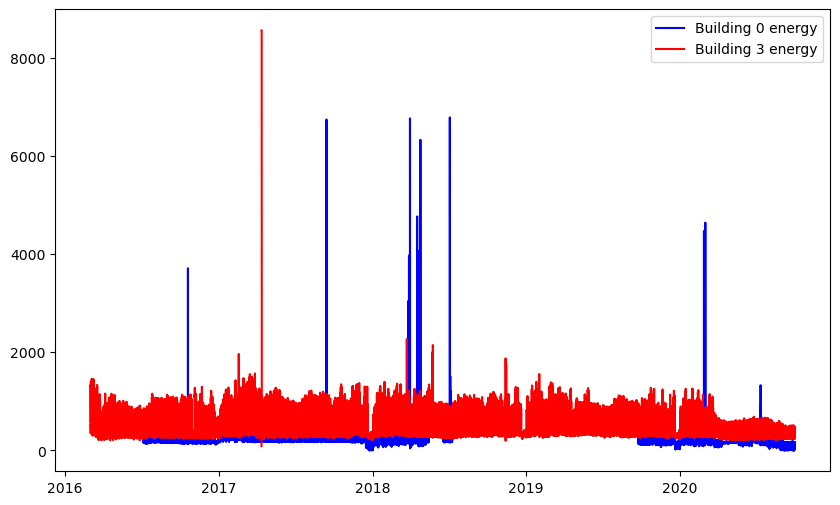

In [10]:
plt.figure(figsize = (10,6))
plt.plot(final_time_series.index, final_time_series['building 0'], label = 'Building 0 energy', color = 'blue')
plt.plot(final_time_series.index, final_time_series['building 3'], label = 'Building 3 energy', color = 'red')
plt.legend()

In [11]:
building_energy_smoothed = final_time_series.rolling('7D').mean()
building_energy_smoothed

,building 0,building 1,building 3,building 4,building 5,building 6
2016-03-01 04:15:00,NaN,NaN,1321.000000,NaN,NaN,NaN
2016-03-01 04:30:00,NaN,NaN,1321.000000,NaN,NaN,NaN
2016-03-01 04:45:00,NaN,NaN,1321.000000,NaN,NaN,NaN
2016-03-01 05:00:00,NaN,NaN,1321.000000,NaN,NaN,NaN
2016-03-01 05:15:00,NaN,NaN,1315.400000,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-09-30 22:45:00,117.939091,9.559821,335.061012,1.481771,11.6875,32.753593
2020-09-30 23:00:00,117.898182,9.560268,335.023810,1.480519,11.6875,32.752695
2020-09-30 23:15:00,117.817121,9.559524,334.995536,1.481771,11.6875,32.751796
2020-09-30 23:30:00,117.736061,9.559673,334.967262,1.481771,11.6875,32.748802


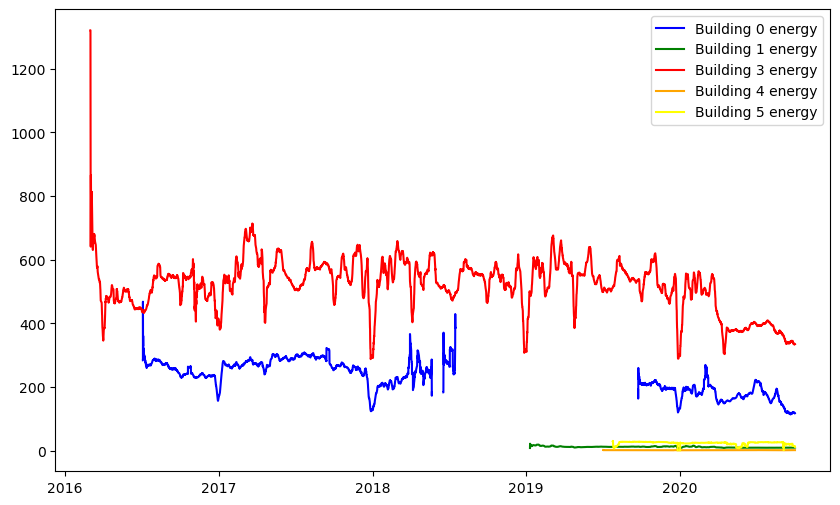

In [12]:
plt.figure(figsize = (10,6))
plt.plot(building_energy_smoothed.index, building_energy_smoothed['building 0'], label = 'Building 0 energy', color = 'blue')
plt.plot(building_energy_smoothed.index, building_energy_smoothed['building 1'], label = 'Building 1 energy', color = 'green')
plt.plot(building_energy_smoothed.index, building_energy_smoothed['building 3'], label = 'Building 3 energy', color = 'red')
plt.plot(building_energy_smoothed.index, building_energy_smoothed['building 4'], label = 'Building 4 energy', color = 'orange')
plt.plot(building_energy_smoothed.index, building_energy_smoothed['building 5'], label = 'Building 5 energy', color = 'yellow')
#plt.plot(building_energy_smoothed.index, building_energy_smoothed['building 6'], label = 'Building 6 energy', color = 'brown')
plt.legend()

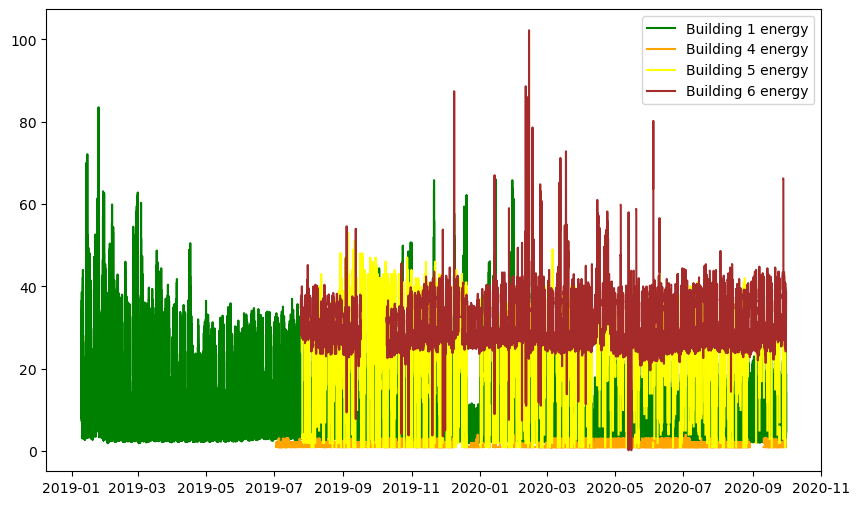

In [13]:
plt.figure(figsize = (10,6))
plt.plot(final_time_series.index, final_time_series['building 1'], label = 'Building 1 energy', color = 'green')
plt.plot(final_time_series.index, final_time_series['building 4'], label = 'Building 4 energy', color = 'orange')
plt.plot(final_time_series.index, final_time_series['building 5'], label = 'Building 5 energy', color = 'yellow')
plt.plot(final_time_series.index, final_time_series['building 6'], label = 'Building 6 energy', color = 'brown')
plt.legend()

In [14]:
data['utc_offset (hrs)'].unique()

array([10.])

In [15]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100057 entries, 0 to 100056
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   datetime (UTC)                     100057 non-null  object 
 1   coordinates (lat,lon)              100057 non-null  object 
 2   model (name)                       100057 non-null  object 
 3   model elevation (surface)          100057 non-null  float64
 4   utc_offset (hrs)                   100057 non-null  float64
 5   temperature (degC)                 100057 non-null  float64
 6   dewpoint_temperature (degC)        100057 non-null  float64
 7   wind_speed (m/s)                   100057 non-null  float64
 8   mean_sea_level_pressure (Pa)       100057 non-null  float64
 9   relative_humidity ((0-1))          100057 non-null  float64
 10  surface_solar_radiation (W/m^2)    100057 non-null  float64
 11  surface_thermal_radiation (W/m^2)  1000

In [16]:
data['datetime']=pd.to_datetime(data['datetime (UTC)'])
data.set_index('datetime',inplace = True)


In [161]:
start_date = '2016-03-01 04:15:00'
end_date = '2020-11-30 23:45:00'
filter_data = data.loc[start_date:end_date]
filter_data

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime,,,,,,,,,,,,,
2016-03-01 05:00:00,2016-03-01 05:00:00,"(-37.91, 145.13)",era5,69.59,10.0,30.99,10.72,3.06,101381.97,0.29,774.98,365.04,0.96
2016-03-01 06:00:00,2016-03-01 06:00:00,"(-37.91, 145.13)",era5,69.59,10.0,30.30,10.51,2.31,101360.51,0.29,627.02,363.57,1.00
2016-03-01 07:00:00,2016-03-01 07:00:00,"(-37.91, 145.13)",era5,69.59,10.0,30.28,9.68,1.84,101352.73,0.28,415.35,360.93,1.00
2016-03-01 08:00:00,2016-03-01 08:00:00,"(-37.91, 145.13)",era5,69.59,10.0,28.21,10.91,3.12,101401.62,0.34,184.91,364.16,0.96
2016-03-01 09:00:00,2016-03-01 09:00:00,"(-37.91, 145.13)",era5,69.59,10.0,27.29,13.15,4.19,101488.30,0.42,40.14,362.36,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,2020-11-30 19:00:00,"(-37.91, 145.13)",era5,69.59,10.0,20.39,12.65,5.38,100288.78,0.61,0.17,345.16,0.51
2020-11-30 20:00:00,2020-11-30 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,21.29,13.14,6.06,100269.32,0.60,57.54,340.41,0.88
2020-11-30 21:00:00,2020-11-30 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,22.12,13.44,6.24,100262.43,0.58,219.35,338.43,1.00


In [162]:
data_duplicates = data.duplicated(subset=['datetime (UTC)'])
print(f"Number of duplicate datetime entries: {data_duplicates.sum()}")
data0 = data.drop_duplicates(subset=['datetime (UTC)'])
print(f"Number of rows after removing duplicates: {len(data0)}")


Number of duplicate datetime entries: 0
Number of rows after removing duplicates: 100057


In [163]:
data['temperature (degC)']

datetime
2010-01-01 00:00:00    18.26
2010-01-01 01:00:00    18.67
2010-01-01 02:00:00    18.16
2010-01-01 03:00:00    18.46
2010-01-01 04:00:00    18.53
                       ...  
2021-05-31 20:00:00     8.31
2021-05-31 21:00:00     8.15
2021-05-31 22:00:00     8.72
2021-05-31 23:00:00     9.83
2021-06-01 00:00:00    10.73
Name: temperature (degC), Length: 100057, dtype: float64

In [164]:
single_day_temp = data['temperature (degC)'].mean()
print(single_day_temp)

14.802317778866366


In [165]:


model_5_start = solar_datetime_5
model_5_end = end_solar_5
model_5 = data.loc['2016-07-03 21:30:00':'2020-11-30 23:45:00']
model_5
print(model_5_start)
print(model_5_end)

2019-01-15 13:00:00
2020-11-30 23:45:00


In [166]:
model_5

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime,,,,,,,,,,,,,
2016-07-03 22:00:00,2016-07-03 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,10.28,5.96,5.25,101761.32,0.75,1.92,322.24,1.00
2016-07-03 23:00:00,2016-07-03 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,10.42,5.98,5.44,101766.59,0.74,42.34,320.45,1.00
2016-07-04 00:00:00,2016-07-04 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,10.91,6.24,5.31,101762.57,0.73,102.41,318.20,1.00
2016-07-04 01:00:00,2016-07-04 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,10.89,6.31,5.36,101681.93,0.73,135.77,322.20,1.00
2016-07-04 02:00:00,2016-07-04 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,11.23,6.54,5.30,101591.95,0.73,176.84,320.79,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,2020-11-30 19:00:00,"(-37.91, 145.13)",era5,69.59,10.0,20.39,12.65,5.38,100288.78,0.61,0.17,345.16,0.51
2020-11-30 20:00:00,2020-11-30 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,21.29,13.14,6.06,100269.32,0.60,57.54,340.41,0.88
2020-11-30 21:00:00,2020-11-30 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,22.12,13.44,6.24,100262.43,0.58,219.35,338.43,1.00


In [243]:
building3data_predict_df

,datetime,Building 3
0,2016-07-03 21:00:00,581.00
1,2016-07-03 22:00:00,613.25
2,2016-07-03 23:00:00,707.25
3,2016-07-04 00:00:00,763.50
4,2016-07-04 01:00:00,802.25
...,...,...
38662,2020-11-30 19:00:00,291.00
38663,2020-11-30 20:00:00,397.75
38664,2020-11-30 21:00:00,465.00
38665,2020-11-30 22:00:00,534.50


In [244]:
print(building3data_predict_df.columns)

Index(['datetime', 'Building 3'], dtype='object')


In [245]:
building3data['datetime'] = pd.to_datetime(building3data['datetime'])
building3data_predict_df.set_index('datetime', inplace=True)

In [246]:
building3data_predict_df

,Building 3
datetime,
2016-07-03 21:00:00,581.00
2016-07-03 22:00:00,613.25
2016-07-03 23:00:00,707.25
2016-07-04 00:00:00,763.50
2016-07-04 01:00:00,802.25
...,...
2020-11-30 19:00:00,291.00
2020-11-30 20:00:00,397.75
2020-11-30 21:00:00,465.00


In [247]:
model_5 = data.loc['2016-07-03 21:30:00':'2020-11-30 23:00:00']
model_5['month'] = model_5.index.month
model_5['hour'] = model_5.index.hour
model_5['day'] = model_5.index.day
new_data = model_5.drop(columns = ['mean_sea_level_pressure (Pa)'])
new_data['Building 3'] = building3data_predict_df['Building 3']


C:\Users\steve\AppData\Local\Temp\ipykernel_17752\2813463550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_5['month'] = model_5.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\2813463550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_5['hour'] = model_5.index.hour
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\2813463550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [248]:
new_data

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),month,hour,day,Building 3
datetime,,,,,,,,,,,,,,,,
2016-07-03 22:00:00,2016-07-03 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,10.28,5.96,5.25,0.75,1.92,322.24,1.00,7,22,3,613.25
2016-07-03 23:00:00,2016-07-03 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,10.42,5.98,5.44,0.74,42.34,320.45,1.00,7,23,3,707.25
2016-07-04 00:00:00,2016-07-04 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,10.91,6.24,5.31,0.73,102.41,318.20,1.00,7,0,4,763.50
2016-07-04 01:00:00,2016-07-04 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,10.89,6.31,5.36,0.73,135.77,322.20,1.00,7,1,4,802.25
2016-07-04 02:00:00,2016-07-04 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,11.23,6.54,5.30,0.73,176.84,320.79,1.00,7,2,4,802.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,2020-11-30 19:00:00,"(-37.91, 145.13)",era5,69.59,10.0,20.39,12.65,5.38,0.61,0.17,345.16,0.51,11,19,30,291.00
2020-11-30 20:00:00,2020-11-30 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,21.29,13.14,6.06,0.60,57.54,340.41,0.88,11,20,30,397.75
2020-11-30 21:00:00,2020-11-30 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,22.12,13.44,6.24,0.58,219.35,338.43,1.00,11,21,30,465.00


In [249]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = new_data[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
y = new_data['Building 3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
upper_model = RandomForestRegressor(n_estimators = 100)
upper_model.fit(X_train, y_train)

predictions = upper_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, predictions)
print("R^2 Score:", r2)

correlation_matrix = new_data.corr()
print(correlation_matrix['Building 3'].abs().sort_values(ascending=False))
# Get feature importances
feature_importances = upper_model.feature_importances_
print(feature_importances)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Mean Squared Error: 30182.178800119244
R^2 Score: 0.5731103219098874
Building 3                           1.000000
surface_solar_radiation (W/m^2)      0.537142
hour                                 0.436351
relative_humidity ((0-1))            0.422487
temperature (degC)                   0.355528
surface_thermal_radiation (W/m^2)    0.179674
wind_speed (m/s)                     0.095461
dewpoint_temperature (degC)          0.080004
month                                0.078161
day                                  0.013116
total_cloud_cover (0-1)              0.000629
model elevation (surface)                 NaN
utc_offset (hrs)                          NaN
Name: Building 3, dtype: float64
[0.12044513 0.04759418 0.12346739 0.09111873 0.44759316 0.09847201
 0.07130941]
                             Feature  Importance
4    surface_solar_radiation (W/m^2)    0.447593
2                 temperature (degC)    0.123467
0                               hour    0.120445
5                   wind

In [280]:
start_date = '2020-12-1 00:00:00'
end_date = '2020-12-7 23:00:00'
upper_data = data.loc[start_date:end_date]
upper_data['month'] = upper_data.index.month
upper_data['hour'] = upper_data.index.hour
for_model = upper_data[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
dec_predictions = upper_model.predict(for_model)
date_range = pd.date_range(start = start_date, end = end_date, freq = 'H')
dec_week_1 = pd.DataFrame({'Building 3 predictions':dec_predictions}, index = date_range)
dec_week_1

C:\Users\steve\AppData\Local\Temp\ipykernel_17752\2894419546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_data['month'] = upper_data.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\2894419546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_data['hour'] = upper_data.index.hour


,Building 3 predictions
2020-12-01 00:00:00,613.3225
2020-12-01 01:00:00,706.9275
2020-12-01 02:00:00,761.7600
2020-12-01 03:00:00,574.7150
2020-12-01 04:00:00,679.1850
...,...
2020-12-07 19:00:00,304.6350
2020-12-07 20:00:00,331.3175
2020-12-07 21:00:00,515.0275
2020-12-07 22:00:00,545.2475


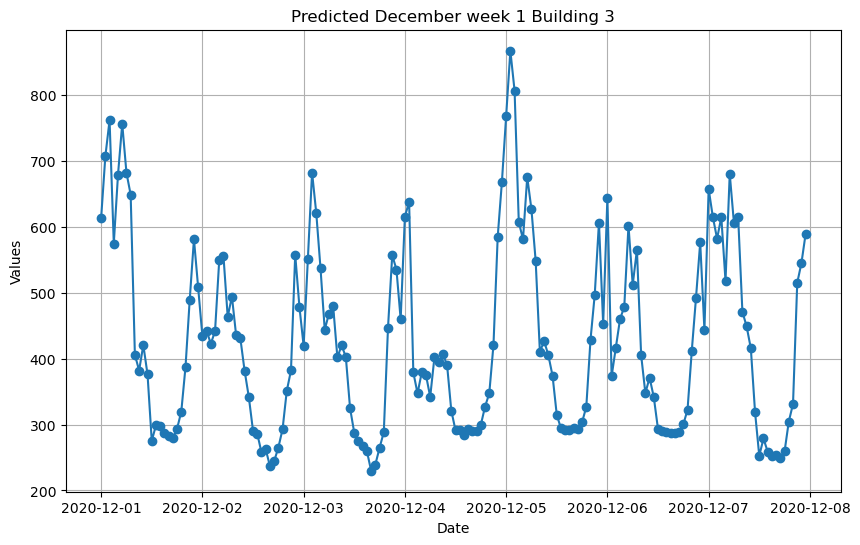

In [281]:
plt.figure(figsize=(10, 6))
plt.plot(dec_week_1.index, dec_week_1['Building 3 predictions'], marker='o', linestyle='-')
plt.title('Predicted December week 1 Building 3')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [260]:
model_5_start = solar_datetime_5
model_5_end = end_solar_5

model_5 = data.loc['2019-07-26 00:00:00':'2020-11-30 23:00:00']
model_5['Building 6'] = building6data_predict['Building 6']
model_5['month'] = model_5.index.month
model_5['hour'] = model_5.index.hour
model_5['day'] = model_5.index.day
new_data1 = model_5.drop(columns = ['mean_sea_level_pressure (Pa)'])
new_data1

C:\Users\steve\AppData\Local\Temp\ipykernel_17752\3034010828.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_5['Building 6'] = building6data_predict['Building 6']
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\3034010828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_5['month'] = model_5.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\3034010828.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building 6,month,hour,day
datetime,,,,,,,,,,,,,,,,
2019-07-26 00:00:00,2019-07-26 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,11.57,8.06,4.88,0.79,125.23,329.70,0.99,37.5,7,0,26
2019-07-26 01:00:00,2019-07-26 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,11.74,8.37,4.49,0.80,225.86,326.13,0.87,37.4,7,1,26
2019-07-26 02:00:00,2019-07-26 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.30,8.70,3.82,0.79,225.36,335.45,0.90,36.2,7,2,26
2019-07-26 03:00:00,2019-07-26 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.46,9.23,2.84,0.81,202.20,343.44,1.00,34.7,7,3,26
2019-07-26 04:00:00,2019-07-26 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.58,9.35,1.99,0.81,194.53,349.33,1.00,33.7,7,4,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,2020-11-30 19:00:00,"(-37.91, 145.13)",era5,69.59,10.0,20.39,12.65,5.38,0.61,0.17,345.16,0.51,26.6,11,19,30
2020-11-30 20:00:00,2020-11-30 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,21.29,13.14,6.06,0.60,57.54,340.41,0.88,32.0,11,20,30
2020-11-30 21:00:00,2020-11-30 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,22.12,13.44,6.24,0.58,219.35,338.43,1.00,39.3,11,21,30


In [261]:
new_data1.isna().sum()

datetime (UTC)                       0
coordinates (lat,lon)                0
model (name)                         0
model elevation (surface)            0
utc_offset (hrs)                     0
temperature (degC)                   0
dewpoint_temperature (degC)          0
wind_speed (m/s)                     0
relative_humidity ((0-1))            0
surface_solar_radiation (W/m^2)      0
surface_thermal_radiation (W/m^2)    0
total_cloud_cover (0-1)              0
Building 6                           0
month                                0
hour                                 0
day                                  0
dtype: int64

In [262]:
model_5_start = solar_datetime_5
model_5_end = end_solar_5

model_5 = data.loc['2019-07-26 00:00:00':'2020-11-30 23:00:00']
model_5['Building 6'] = building6data_predict['Building 6']
model_5['month'] = model_5.index.month
model_5['hour'] = model_5.index.hour
model_5['day'] = model_5.index.day
new_data1 = model_5.drop(columns = ['mean_sea_level_pressure (Pa)','day'])

C:\Users\steve\AppData\Local\Temp\ipykernel_17752\2178985081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_5['Building 6'] = building6data_predict['Building 6']
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\2178985081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_5['month'] = model_5.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\2178985081.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [263]:
new_data1

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building 6,month,hour
datetime,,,,,,,,,,,,,,,
2019-07-26 00:00:00,2019-07-26 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,11.57,8.06,4.88,0.79,125.23,329.70,0.99,37.5,7,0
2019-07-26 01:00:00,2019-07-26 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,11.74,8.37,4.49,0.80,225.86,326.13,0.87,37.4,7,1
2019-07-26 02:00:00,2019-07-26 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.30,8.70,3.82,0.79,225.36,335.45,0.90,36.2,7,2
2019-07-26 03:00:00,2019-07-26 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.46,9.23,2.84,0.81,202.20,343.44,1.00,34.7,7,3
2019-07-26 04:00:00,2019-07-26 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.58,9.35,1.99,0.81,194.53,349.33,1.00,33.7,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,2020-11-30 19:00:00,"(-37.91, 145.13)",era5,69.59,10.0,20.39,12.65,5.38,0.61,0.17,345.16,0.51,26.6,11,19
2020-11-30 20:00:00,2020-11-30 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,21.29,13.14,6.06,0.60,57.54,340.41,0.88,32.0,11,20
2020-11-30 21:00:00,2020-11-30 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,22.12,13.44,6.24,0.58,219.35,338.43,1.00,39.3,11,21


In [264]:
X = new_data1[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
y = new_data1['Building 6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lower_model = RandomForestRegressor(n_estimators = 100)
lower_model.fit(X_train, y_train)

predictions = upper_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, predictions)
print("R^2 Score:", r2)

correlation_matrix = new_data1.corr()
print(correlation_matrix['Building 6'].abs().sort_values(ascending=False))
# Get feature importances
feature_importances = lower_model.feature_importances_
print(feature_importances)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# print(feature_importance_df)re

Mean Squared Error: 233372.82833974026
R^2 Score: -3344.1459480120852
Building 6                           1.000000
surface_solar_radiation (W/m^2)      0.301493
temperature (degC)                   0.235414
hour                                 0.217201
relative_humidity ((0-1))            0.211357
surface_thermal_radiation (W/m^2)    0.152093
month                                0.148008
dewpoint_temperature (degC)          0.124468
wind_speed (m/s)                     0.082238
total_cloud_cover (0-1)              0.037721
model elevation (surface)                 NaN
utc_offset (hrs)                          NaN
Name: Building 6, dtype: float64
[0.0563602  0.16396821 0.15618287 0.14023142 0.21159939 0.16426742
 0.10739049]


In [265]:
start_date = '2020-12-1 00:00:00'
end_date = '2020-12-7 23:00:00'
lower_data = data.loc[start_date:end_date]
lower_data['month'] = lower_data.index.month
lower_data['hour'] = lower_data.index.hour
for_model = lower_data[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
december_predictions1 = lower_model.predict(for_model)
date_range = pd.date_range(start = start_date, end = end_date, freq = 'H')
dec_week_1s = pd.DataFrame({'Building 6 predictions':december_predictions1}, index = date_range)

C:\Users\steve\AppData\Local\Temp\ipykernel_17752\32820705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_data['month'] = lower_data.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\32820705.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_data['hour'] = lower_data.index.hour


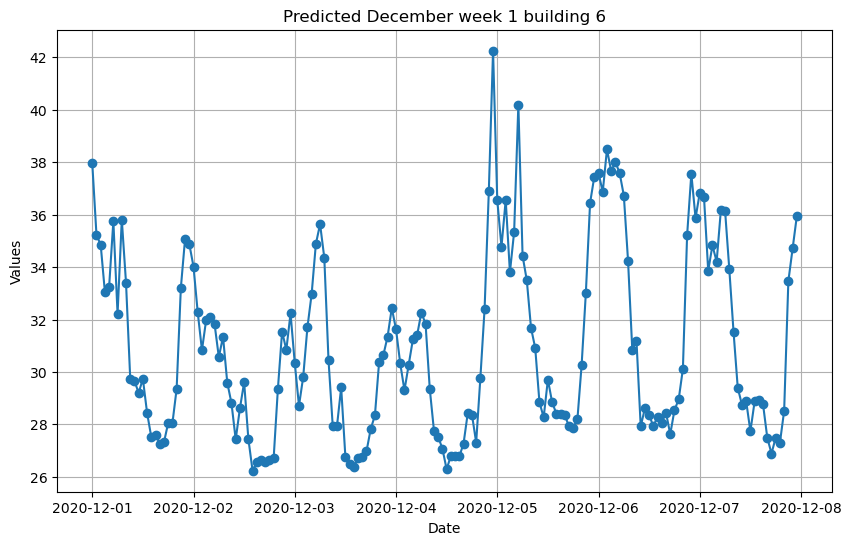

In [266]:
plt.figure(figsize=(10, 6))
plt.plot(dec_week_1s.index, dec_week_1s['Building 6 predictions'], marker='o', linestyle='-')
plt.title('Predicted December week 1 building 6')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [267]:
dec_week_1.max()

Building 3 predictions    867.23
dtype: float64

In [268]:
dec_week_1s.max()

Building 6 predictions    42.2525
dtype: float64

In [270]:
dec_week_1

,Building 3 predictions
2020-12-01 00:00:00,613.3225
2020-12-01 01:00:00,706.9275
2020-12-01 02:00:00,761.7600
2020-12-01 03:00:00,574.7150
2020-12-01 04:00:00,679.1850
...,...
2020-12-07 19:00:00,304.6350
2020-12-07 20:00:00,331.3175
2020-12-07 21:00:00,515.0275
2020-12-07 22:00:00,545.2475


In [276]:
dec_week_1['Building 0 predictions'] = dec_week_1['Building 3 predictions'] * (222.864/513.108)
dec_week_1['Building 1 predictions'] = dec_week_1s['Building 6 predictions'] * (11.184/30.532)
dec_week_1['Building 4 predictions'] = dec_week_1s['Building 6 predictions'] * (1.33/30.532)
dec_week_1['Building 5 predictions'] = dec_week_1s['Building 6 predictions'] * (24.643/4.139)
dec_week_1['Building 6 predictions'] = dec_week_1s['Building 6 predictions'] 
dec_week_1['total'] = dec_week_1['Building 0 predictions'] + dec_week_1['Building 1 predictions'] + dec_week_1['Building 3 predictions'] + dec_week_1['Building 4 predictions'] + dec_week_1['Building 5 predictions'] + dec_week_1['Building 6 predictions']
dec_week_1.columns = ['Building 0 predictions', 'Building 1 predictions', 'Building 3 predictions', 'Building 4 predictions', 'Building 5 predictions', 'Building 6 predictions','total']
dec_week_1

,Building 0 predictions,Building 1 predictions,Building 3 predictions,Building 4 predictions,Building 5 predictions,Building 6 predictions,total
2020-12-01 00:00:00,613.3225,266.391297,13.907289,1.653853,226.046982,37.9665,1159.288421
2020-12-01 01:00:00,706.9275,307.047815,12.904348,1.534584,209.745331,35.2285,1273.388078
2020-12-01 02:00:00,761.7600,330.863835,12.764786,1.517987,207.476913,34.8475,1349.231021
2020-12-01 03:00:00,574.7150,249.622465,12.101409,1.439098,196.694484,33.0365,1067.608956
2020-12-01 04:00:00,679.1850,294.998101,12.182545,1.448747,198.013263,33.2580,1219.085656
...,...,...,...,...,...,...,...
2020-12-07 19:00:00,304.6350,132.315564,10.000105,1.189211,162.540203,27.3000,637.980084
2020-12-07 20:00:00,331.3175,143.904876,10.445164,1.242138,169.774135,28.5150,685.198814
2020-12-07 21:00:00,515.0275,223.697718,12.258004,1.457720,199.239756,33.4640,985.144699
2020-12-07 22:00:00,545.2475,236.823512,12.713870,1.511932,206.649327,34.7085,1037.654641


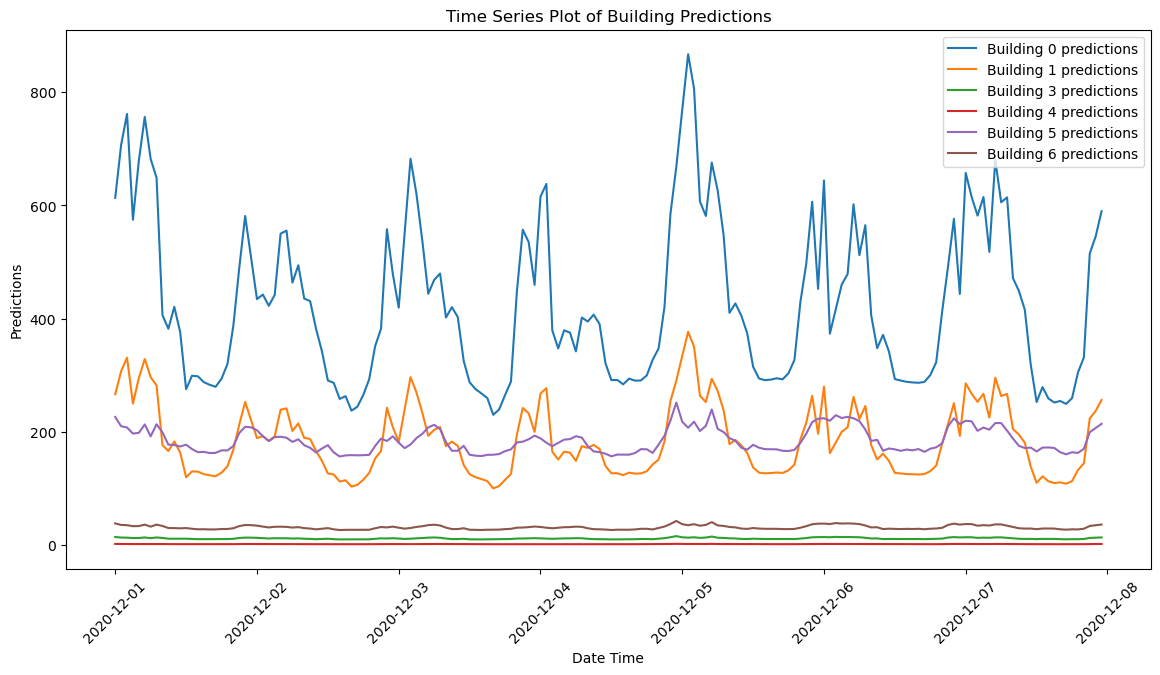

In [278]:
import matplotlib.pyplot as plt

# Plot the time series for each building's predictions
plt.figure(figsize=(14, 7))

plt.plot(dec_week_1.index, dec_week_1['Building 0 predictions'], label='Building 0 predictions')
plt.plot(dec_week_1.index, dec_week_1['Building 1 predictions'], label='Building 1 predictions')
plt.plot(dec_week_1.index, dec_week_1['Building 3 predictions'], label='Building 3 predictions')
plt.plot(dec_week_1.index, dec_week_1['Building 4 predictions'], label='Building 4 predictions')
plt.plot(dec_week_1.index, dec_week_1['Building 5 predictions'], label='Building 5 predictions')
plt.plot(dec_week_1.index, dec_week_1['Building 6 predictions'], label='Building 6 predictions')
# Add labels and title
plt.xlabel('Date Time')
plt.ylabel('Predictions')
plt.title('Time Series Plot of Building Predictions')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [301]:
start_date = '2020-10-1 00:00:00'
end_date = '2020-10-7 23:00:00'
lower_data = data.loc[start_date:end_date]
lower_data['month'] = lower_data.index.month
lower_data['hour'] = lower_data.index.hour
for_model = lower_data[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
oct_predictions1 = lower_model.predict(for_model)
date_range = pd.date_range(start = start_date, end = end_date, freq = 'H')
oct_week_1s = pd.DataFrame({'Building 6 predictions':december_predictions1}, index = date_range)

C:\Users\steve\AppData\Local\Temp\ipykernel_17752\3491969388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_data['month'] = lower_data.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\3491969388.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_data['hour'] = lower_data.index.hour


In [302]:
start_date = '2020-10-1 00:00:00'
end_date = '2020-10-7 23:00:00'
upper_data = data.loc[start_date:end_date]
upper_data['month'] = upper_data.index.month
upper_data['hour'] = upper_data.index.hour
for_model = upper_data[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
oct_predictions = upper_model.predict(for_model)
date_range = pd.date_range(start = start_date, end = end_date, freq = 'H')
oct_week_1 = pd.DataFrame({'Building 3 predictions':oct_predictions}, index = date_range)
oct_week_1

C:\Users\steve\AppData\Local\Temp\ipykernel_17752\148749795.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_data['month'] = upper_data.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\148749795.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_data['hour'] = upper_data.index.hour


,Building 3 predictions
2020-10-01 00:00:00,555.3600
2020-10-01 01:00:00,546.5625
2020-10-01 02:00:00,564.8375
2020-10-01 03:00:00,542.0700
2020-10-01 04:00:00,735.6175
...,...
2020-10-07 19:00:00,279.7300
2020-10-07 20:00:00,397.5450
2020-10-07 21:00:00,403.0875
2020-10-07 22:00:00,501.2825


In [303]:
oct_week_1

,Building 3 predictions
2020-10-01 00:00:00,555.3600
2020-10-01 01:00:00,546.5625
2020-10-01 02:00:00,564.8375
2020-10-01 03:00:00,542.0700
2020-10-01 04:00:00,735.6175
...,...
2020-10-07 19:00:00,279.7300
2020-10-07 20:00:00,397.5450
2020-10-07 21:00:00,403.0875
2020-10-07 22:00:00,501.2825


In [304]:
oct_week_1s

,Building 6 predictions
2020-10-01 00:00:00,37.9665
2020-10-01 01:00:00,35.2285
2020-10-01 02:00:00,34.8475
2020-10-01 03:00:00,33.0365
2020-10-01 04:00:00,33.2580
...,...
2020-10-07 19:00:00,27.3000
2020-10-07 20:00:00,28.5150
2020-10-07 21:00:00,33.4640
2020-10-07 22:00:00,34.7085


In [305]:
oct_week_1['Building 0 predictions'] = oct_week_1['Building 3 predictions'] * (222.864/513.108)
oct_week_1['Building 1 predictions'] = oct_week_1s['Building 6 predictions'] * (11.184/30.532)
oct_week_1['Building 4 predictions'] = oct_week_1s['Building 6 predictions'] * (1.33/30.532)
oct_week_1['Building 5 predictions'] = oct_week_1s['Building 6 predictions'] * (24.643/4.139)
oct_week_1['Building 6 predictions'] = oct_week_1s['Building 6 predictions'] 
oct_week_1['total'] = oct_week_1['Building 0 predictions'] + oct_week1_predic['Building 1 predictions'] + oct_week1_predic['Building 3 predictions'] + oct_week1_predic['Building 4 predictions'] + oct_week1_predic['Building 5 predictions'] + oct_week1_predic['Building 6 predictions']
oct_week_1.columns = ['Building 0 predictions', 'Building 1 predictions', 'Building 3 predictions', 'Building 4 predictions', 'Building 5 predictions', 'Building 6 predictions','total']
oct_week_1

,Building 0 predictions,Building 1 predictions,Building 3 predictions,Building 4 predictions,Building 5 predictions,Building 6 predictions,total
2020-10-01 00:00:00,555.3600,241.215789,13.907289,1.653853,226.046982,37.9665,737.978638
2020-10-01 01:00:00,546.5625,237.394671,12.904348,1.534584,209.745331,35.2285,738.301914
2020-10-01 02:00:00,564.8375,245.332259,12.764786,1.517987,207.476913,34.8475,754.066055
2020-10-01 03:00:00,542.0700,235.443393,12.101409,1.439098,196.694484,33.0365,763.462098
2020-10-01 04:00:00,735.6175,319.509067,12.182545,1.448747,198.013263,33.2580,919.718416
...,...,...,...,...,...,...,...
2020-10-07 19:00:00,279.7300,121.498294,10.000105,1.189211,162.540203,27.3000,409.373618
2020-10-07 20:00:00,397.5450,172.670215,10.445164,1.242138,169.774135,28.5150,558.445232
2020-10-07 21:00:00,403.0875,175.077552,12.258004,1.457720,199.239756,33.4640,595.506073
2020-10-07 22:00:00,501.2825,217.727697,12.713870,1.511932,206.649327,34.7085,648.730767


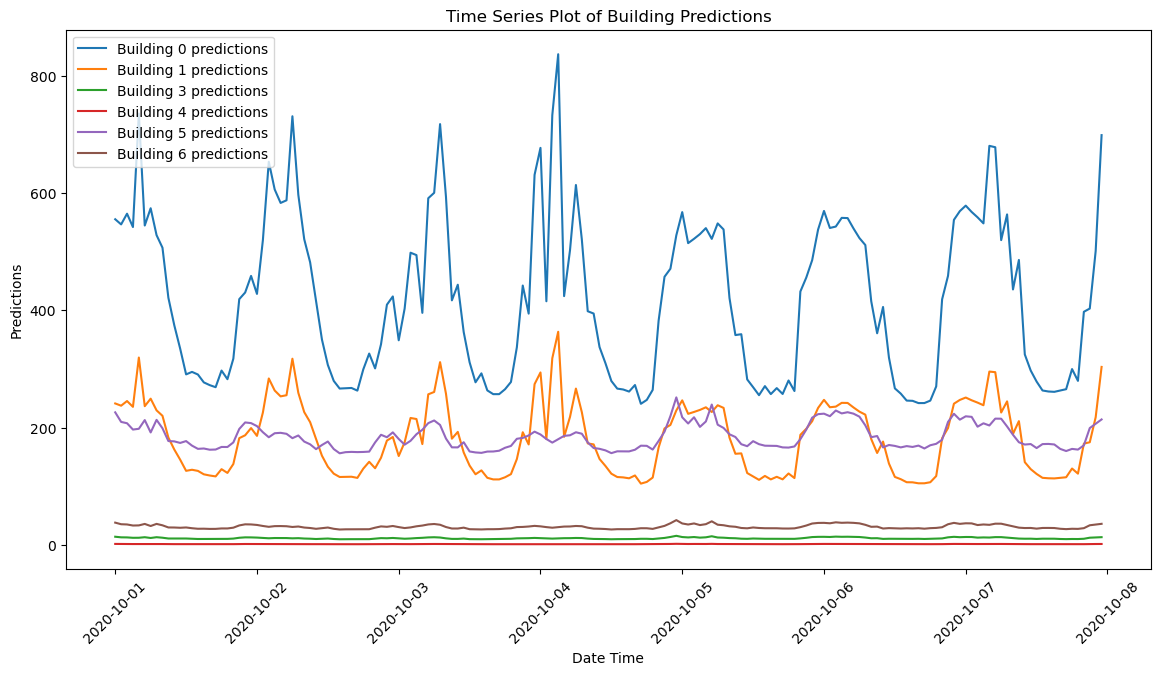

In [308]:
import matplotlib.pyplot as plt

# Plot the time series for each building's predictions
plt.figure(figsize=(14, 7))

plt.plot(oct_week_1.index, oct_week_1['Building 0 predictions'], label='Building 0 predictions')
plt.plot(oct_week_1.index, oct_week_1['Building 1 predictions'], label='Building 1 predictions')
plt.plot(oct_week_1.index, oct_week_1['Building 3 predictions'], label='Building 3 predictions')
plt.plot(oct_week_1.index, oct_week_1['Building 4 predictions'], label='Building 4 predictions')
plt.plot(oct_week_1.index, oct_week_1['Building 5 predictions'], label='Building 5 predictions')
plt.plot(oct_week_1.index, oct_week_1['Building 6 predictions'], label='Building 6 predictions')
# Add labels and title
plt.xlabel('Date Time')
plt.ylabel('Predictions')
plt.title('Time Series Plot of Building Predictions')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [92]:
oct_week_1
daily_mean_total = oct_week_1['total'].resample('D').mean()no

,Building 3 predictions
2020-10-01 00:00:00,501.4900
2020-10-01 01:00:00,524.7050
2020-10-01 02:00:00,518.1075
2020-10-01 03:00:00,580.0550
2020-10-01 04:00:00,766.3100
...,...
2020-10-07 19:00:00,284.9375
2020-10-07 20:00:00,400.3650
2020-10-07 21:00:00,425.5325
2020-10-07 22:00:00,516.4900


In [115]:
daily_means_df

,Building 0 predictions mean,Building 1 predictions mean,Building 3 predictions mean,Building 4 predictions mean,Building 5 predictions mean,Building 6 predictions mean,Total mean
2020-10-01,418.426250,32.959500,181.739805,12.073203,1.435744,196.236037,842.870540
2020-10-02,416.766389,28.659333,181.018859,10.498034,1.248425,170.633475,808.824515
2020-10-03,415.996667,25.128167,180.684536,9.204553,1.094604,149.609425,781.717953
2020-10-04,422.846250,25.802833,183.659593,9.451686,1.123993,153.626292,796.510648
2020-10-05,408.958958,29.508250,177.627769,10.808996,1.285405,175.687800,803.877178
2020-10-06,403.451146,30.251542,175.235499,11.081267,1.317783,180.113250,801.450486
2020-10-07,438.366979,29.659083,190.400887,10.864247,1.291975,176.585840,847.169011


In [96]:
overall_total = daily_means_df['Total mean'].sum()
print(overall_total)

5682.420330638911


In [97]:
start_date = '2019-07-25 01:00:00'
end_date = '2020-11-3- 23:00:00'
lower_data = data.loc[start_date:end_date]
lower_data['month'] = lower_data.index.month
lower_data['hour'] = lower_data.index.hour
for_model = lower_data[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
october_predictions = lower_model.predict(for_model)
date_range = pd.date_range(start = start_date, end = end_date, freq = 'H')
oct_week_1s = pd.DataFrame({'Building 6 predictions':october_predictions}, index = date_range)

C:\Users\steve\AppData\Local\Temp\ipykernel_17752\1277022087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_data['month'] = lower_data.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\1277022087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_data['hour'] = lower_data.index.hour


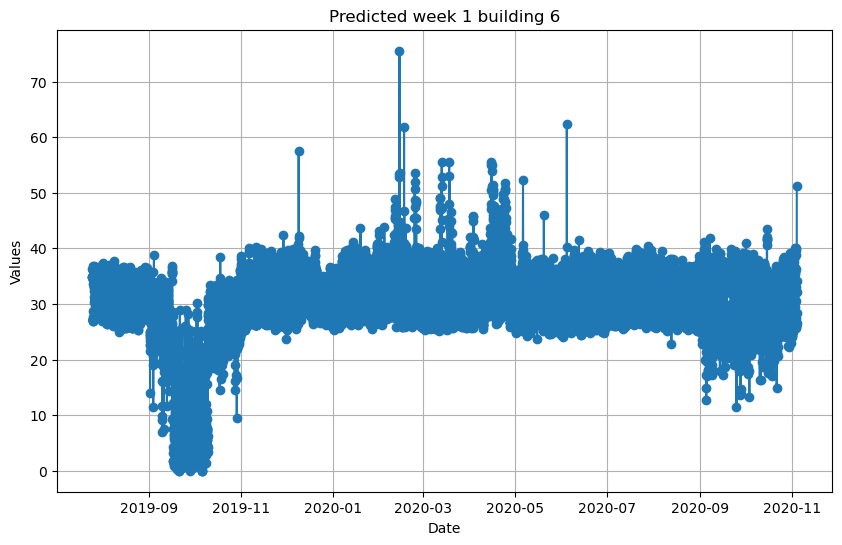

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(oct_week_1s.index, oct_week_1s['Building 6 predictions'], marker='o', linestyle='-')
plt.title('Predicted week 1 building 6')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [99]:
start_date = '2016-07-04 00:00:00'
end_date = '2020-11-30 23:00:00'
upper_data = data.loc[start_date:end_date]
upper_data['month'] = upper_data.index.month
upper_data['hour'] = upper_data.index.hour
for_model = upper_data[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
october_predictions = upper_model.predict(for_model)
date_range = pd.date_range(start = start_date, end = end_date, freq = 'H')
oct_week_1 = pd.DataFrame({'Building 3 predictions':october_predictions}, index = date_range)


C:\Users\steve\AppData\Local\Temp\ipykernel_17752\628788218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_data['month'] = upper_data.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\628788218.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_data['hour'] = upper_data.index.hour


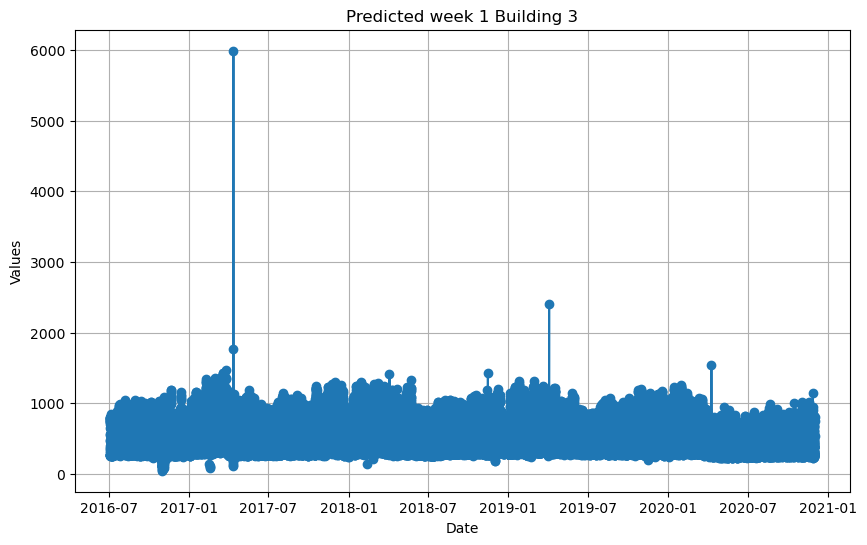

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(oct_week_1.index, oct_week_1['Building 3 predictions'], marker='o', linestyle='-')
plt.title('Predicted week 1 Building 3')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [101]:
oct_week1_predic =  pd.concat([oct_week_1, oct_week_1s], axis=1)

# Renaming the columns for clarity
oct_week1_predic.columns = ['Building 3 predictions', 'Building 6 predictions']

oct_week1_predic

,Building 3 predictions,Building 6 predictions
2016-07-04 00:00:00,757.317500,NaN
2016-07-04 01:00:00,769.315000,NaN
2016-07-04 02:00:00,790.427500,NaN
2016-07-04 03:00:00,809.650000,NaN
2016-07-04 04:00:00,752.240000,NaN
...,...,...
2020-11-30 19:00:00,311.245000,NaN
2020-11-30 20:00:00,418.927500,NaN
2020-11-30 21:00:00,534.212500,NaN
2020-11-30 22:00:00,749.059167,NaN


In [102]:
oct_week1_predic['Building 0 predictions'] = oct_week1_predic['Building 3 predictions'] * (222.864/513.108)
oct_week1_predic['Building 1 predictions'] = oct_week1_predic['Building 6 predictions'] * (11.184/30.532)
oct_week1_predic['Building 4 predictions'] = oct_week1_predic['Building 6 predictions'] * (1.33/30.532)
oct_week1_predic['Building 5 predictions'] = oct_week1_predic['Building 6 predictions'] * (24.643/4.139)
oct_week1_predic['total'] = oct_week1_predic['Building 0 predictions'] + oct_week1_predic['Building 1 predictions'] + oct_week1_predic['Building 3 predictions'] + oct_week1_predic['Building 4 predictions'] + oct_week1_predic['Building 5 predictions'] + oct_week1_predic['Building 6 predictions']
oct_week1_predic.columns = ['Building 0 predictions', 'Building 1 predictions', 'Building 3 predictions', 'Building 4 predictions', 'Building 5 predictions', 'Building 6 predictions','total']
oct_week1_predic = oct_week1_predic.fillna(0)
oct_week1_predic

,Building 0 predictions,Building 1 predictions,Building 3 predictions,Building 4 predictions,Building 5 predictions,Building 6 predictions,total
2016-07-04 00:00:00,757.317500,0.0,328.934274,0.0,0.0,0.0,0.0
2016-07-04 01:00:00,769.315000,0.0,334.145284,0.0,0.0,0.0,0.0
2016-07-04 02:00:00,790.427500,0.0,343.315314,0.0,0.0,0.0,0.0
2016-07-04 03:00:00,809.650000,0.0,351.664440,0.0,0.0,0.0,0.0
2016-07-04 04:00:00,752.240000,0.0,326.728906,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2020-11-30 19:00:00,311.245000,0.0,135.186560,0.0,0.0,0.0,0.0
2020-11-30 20:00:00,418.927500,0.0,181.957518,0.0,0.0,0.0,0.0
2020-11-30 21:00:00,534.212500,0.0,232.030556,0.0,0.0,0.0,0.0
2020-11-30 22:00:00,749.059167,0.0,325.347338,0.0,0.0,0.0,0.0


In [103]:
oct_week1_predic['Building 3 predictions'].min()

18.738569891718704

In [104]:
import pandas as pd

# Assuming `df` is your dataframe with the data shown in the image
# Ensure the index is a datetime index
oct_week1_predic.index = pd.to_datetime(oct_week1_predic.index)

# Resample the dataframe by day and compute the mean for the "total" column
daily_mean_total = oct_week1_predic['total'].resample('Y').mean()
print(daily_mean_total)
total_sum = oct_week1_predic['total'].sum()
print(total_sum)

2016-12-31      0.000000
2017-12-31      0.000000
2018-12-31      0.000000
2019-12-31    406.930080
2020-12-31    806.669369
Freq: A-DEC, Name: total, dtype: float64
10050329.222479984


In [95]:
import pandas as pd

# Assuming oct_week1_predic is your dataframe and the datetime index has been set correctly

# Resample the dataframe by day and compute the mean for each column
daily_mean_total = oct_week1_predic['total'].resample('Y').mean()
predict0mean = oct_week1_predic['Building 0 predictions'].resample('Y').mean()
predict1mean = oct_week1_predic['Building 1 predictions'].resample('Y').mean()
predict3mean = oct_week1_predic['Building 3 predictions'].resample('Y').mean()
predict4mean = oct_week1_predic['Building 4 predictions'].resample('Y').mean()
predict5mean = oct_week1_predic['Building 5 predictions'].resample('Y').mean()
predict6mean = oct_week1_predic['Building 6 predictions'].resample('Y').mean()

# Combine all the series into a single dataframe
annualmean = pd.concat([predict0mean, predict1mean, predict3mean, predict4mean, predict5mean, predict6mean, daily_mean_total], axis=1)

# Rename the columns for clarity
annualmean.columns = [
    'Building 0 predictions mean', 
    'Building 1 predictions mean', 
    'Building 3 predictions mean', 
    'Building 4 predictions mean', 
    'Building 5 predictions mean', 
    'Building 6 predictions mean', 
    'Total mean'
]
annualmean


,Building 0 predictions mean,Building 1 predictions mean,Building 3 predictions mean,Building 4 predictions mean,Building 5 predictions mean,Building 6 predictions mean,Total mean
2020-12-31,417.830377,28.852673,181.480993,10.568855,1.256847,171.784588,811.774333


In [105]:
# Resample the data to hourly frequency, using the mean for aggregation
building0data_predict = building0data.resample('Y').mean()
building0data_predict = building0data_predict.fillna(0)

building1data_predict = building1data.resample('Y').mean()
building1data_predict = building1data_predict.fillna(0)

building3data_predict = building3data.resample('Y').mean()
building3data_predict = building3data_predict.fillna(0)

building4data_predict = building4data.resample('Y').mean()
building4data_predict = building4data_predict.fillna(0)

building5data_predict = building5data.resample('Y').mean()
building5data_predict = building5data_predict.fillna(0)

building6data_predict = building6data.resample('Y').mean()
building6data_predict = building6data_predict.fillna(0)

actual_mean = pd.concat([predict0mean, predict1mean, predict3mean, predict4mean, predict5mean, predict6mean, daily_mean_total], axis=1)
actual_mean 

,Building 0 predictions,Building 1 predictions,Building 3 predictions,Building 4 predictions,Building 5 predictions,Building 6 predictions,total
2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,406.930080
2020-12-31,417.830377,28.852673,181.480993,10.568855,1.256847,171.784588,806.669369


In [106]:
model_5_start = solar_datetime_5
model_5_end = end_solar_5

model_5 = data.loc['2019-01-15 13:00:00':'2020-09-30 23:45:00']
model_5['solar_5'] = solar_data['solar 5']
model_5['month'] = model_5.index.month
model_5['hour'] = model_5.index.hour
model_5['day'] = model_5.index.day
start_date = '2020-04-15'
end_date = '2020-05-19'
new_data = model_5.loc[(model_5.index < start_date) | (model_5.index > end_date)]
new_data = new_data.drop(columns = ['day','mean_sea_level_pressure (Pa)'])

C:\Users\steve\AppData\Local\Temp\ipykernel_17752\324403501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_5['solar_5'] = solar_data['solar 5']
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\324403501.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_5['month'] = model_5.index.month
C:\Users\steve\AppData\Local\Temp\ipykernel_17752\324403501.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [107]:
new_data.isna().sum()

datetime (UTC)                           0
coordinates (lat,lon)                    0
model (name)                             0
model elevation (surface)                0
utc_offset (hrs)                         0
temperature (degC)                       0
dewpoint_temperature (degC)              0
wind_speed (m/s)                         0
relative_humidity ((0-1))                0
surface_solar_radiation (W/m^2)          0
surface_thermal_radiation (W/m^2)        0
total_cloud_cover (0-1)                  0
solar_5                              10931
month                                    0
hour                                     0
dtype: int64

### Solar


In [169]:
solar_0=dfs['series_value'][6]
solar_1=dfs['series_value'][7]
solar_2=dfs['series_value'][8]
solar_3=dfs['series_value'][9]
solar_4=dfs['series_value'][10]
solar_5=dfs['series_value'][11]

solarstart_0 = dfs['start_timestamp'][6]
solarstart_1 = dfs['start_timestamp'][7]
solarstart_2 = dfs['start_timestamp'][8]
solarstart_3 = dfs['start_timestamp'][9]
solarstart_4 = dfs['start_timestamp'][10]
solarstart_5 = dfs['start_timestamp'][11]

solar_datetime_0 = pd.to_datetime(solarstart_0)
solar_datetime_1 = pd.to_datetime(solarstart_1)
solar_datetime_2 = pd.to_datetime(solarstart_2)
solar_datetime_3 = pd.to_datetime(solarstart_3)
solar_datetime_4 = pd.to_datetime(solarstart_4)
solar_datetime_5 = pd.to_datetime(solarstart_5)

solar_length_0=len(solar_0) 
solar_length_1=len(solar_1) 
solar_length_2=len(solar_2) 
solar_length_3=len(solar_3) 
solar_length_4=len(solar_4) 
solar_length_5=len(solar_5)

end_solar_0 = solar_datetime_0 + pd.Timedelta(minutes=15 * (solar_length_0 - 1)) 
end_solar_1 = solar_datetime_1 + pd.Timedelta(minutes=15 * (solar_length_1 - 1))
end_solar_2 = solar_datetime_2 + pd.Timedelta(minutes=15 * (solar_length_2 - 1))
end_solar_3 = solar_datetime_3 + pd.Timedelta(minutes=15 * (solar_length_3 - 1)) 
end_solar_4 = solar_datetime_4 + pd.Timedelta(minutes=15 * (solar_length_4 - 1))
end_solar_5 = solar_datetime_5 + pd.Timedelta(minutes=15 * (solar_length_5 - 1))

solarrange_0 = pd.date_range(start=solar_datetime_0, end=end_solar_0, freq='15T')
solarrange_1 = pd.date_range(start=solar_datetime_1, end=end_solar_1, freq='15T')
solarrange_2 = pd.date_range(start=solar_datetime_2, end=end_solar_2, freq='15T')
solarrange_3 = pd.date_range(start=solar_datetime_3, end=end_solar_3, freq='15T')
solarrange_4 = pd.date_range(start=solar_datetime_4, end=end_solar_4, freq='15T')
solarrange_5 = pd.date_range(start=solar_datetime_5, end=end_solar_5, freq='15T')

solar_time_index = pd.date_range(start='2020-05-01 13:00:00', end='2020-11-30 23:45:00', freq='15T')
solar_data = pd.DataFrame(index=solar_time_index)

solar_data_0 = pd.DataFrame(index = solarrange_0)
solar_data_0['solar 0'] = solar_0

solar_data_1 = pd.DataFrame(index = solarrange_1)
solar_data_1['solar 1'] = solar_1

solar_data_2 = pd.DataFrame(index = solarrange_2)
solar_data_2['solar 2'] = solar_2

solar_data_3 = pd.DataFrame(index = solarrange_3)
solar_data_3['solar 3'] = solar_3

solar_data_4 = pd.DataFrame(index = solarrange_4)
solar_data_4['solar 4'] = solar_4

solar_data_5 = pd.DataFrame(index = solarrange_5)
solar_data_5['solar 5'] = solar_5

solar_data['solar 0'] = solar_data_0['solar 0'].reindex(solar_data.index)
solar_data['solar 1'] = solar_data_1['solar 1'].reindex(solar_data.index)
solar_data['solar 2'] = solar_data_2['solar 2'].reindex(solar_data.index)
solar_data['solar 3'] = solar_data_3['solar 3'].reindex(solar_data.index)
solar_data['solar 4'] = solar_data_4['solar 4'].reindex(solar_data.index)
solar_data['solar 5'] = solar_data_5['solar 5'].reindex(solar_data.index)
solar_data

,solar 0,solar 1,solar 2,solar 3,solar 4,solar 5
2020-05-01 13:00:00,0.00,7.62,3.99,1.10,1.49,0.00
2020-05-01 13:15:00,0.00,7.62,3.99,1.10,1.48,0.00
2020-05-01 13:30:00,0.00,7.62,3.99,1.10,1.48,0.00
2020-05-01 13:45:00,0.00,7.62,3.99,1.10,1.48,0.00
2020-05-01 14:00:00,0.00,7.62,3.99,1.10,1.48,0.00
...,...,...,...,...,...,...
2020-11-30 22:45:00,13.21,2.32,2.21,3.11,1.31,9.86
2020-11-30 23:00:00,8.24,2.21,2.10,1.97,1.25,6.22
2020-11-30 23:15:00,9.42,2.00,1.90,2.24,1.13,7.14
2020-11-30 23:30:00,7.63,1.78,1.70,1.78,1.01,5.64


In [174]:
daily_mean_total = oct_week_1['total'].resample('D').mean()
predict0mean = oct_week_1['solar 0 predictions'].resample('D').mean()
predict1mean = oct_week_1['solar 1 predictions'].resample('D').mean()
predict3mean = oct_week_1['solar 2 predictions'].resample('D').mean()
predict4mean = oct_week_1['solar 3 predictions'].resample('D').mean()
predict5mean = oct_week_1['solar 4 predictions'].resample('D').mean()
predict6mean = oct_week_1['solar 5 predictions'].resample('D').mean()

# Combine all the series into a single dataframe
daily_means_df = pd.concat([predict0mean, predict1mean, predict3mean, predict4mean, predict5mean, predict6mean, daily_mean_total], axis=1)

# Rename the columns for clarity
daily_means_df.columns = [
    'solar 0 predictions mean', 
    'solar 1 predictions mean', 
    'solar 2 predictions mean', 
    'solar 3 predictions mean', 
    'solar 4 predictions mean', 
    'solar 5 predictions mean', 
    'Total mean'
]
daily_means_df

KeyError: 'total'

In [ ]:
solar_data = solar_data.reset_index()
solar_data.rename(columns={'index': 'datetime'}, inplace=True)
solar_data


In [ ]:
solar_duplicates = solar_data.duplicated(subset=['datetime'])
print(f"Number of duplicate datetime entries: {solar_duplicates.sum()}")
data1 = data.drop_duplicates(subset=['datetime (UTC)'])
print(f"Number of rows after removing duplicates: {len(data1)}")


In [ ]:
solar_data1 = solar_data.fillna(0)
solar_data1

In [ ]:
for col in solar_data1.columns:
    print(col)

In [ ]:
solar_data1.isna().sum()

In [ ]:
dfs

# Building


In [175]:
building_0=dfs['series_value'][0]
building_1=dfs['series_value'][1]
building_2=dfs['series_value'][2]
building_3=dfs['series_value'][3]
building_4=dfs['series_value'][4]
building_5=dfs['series_value'][5]

buildingstart_0 = dfs['start_timestamp'][0]
buildingstart_1 = dfs['start_timestamp'][1]
buildingstart_2 = dfs['start_timestamp'][2]
buildingstart_3 = dfs['start_timestamp'][3]
buildingstart_4 = dfs['start_timestamp'][4]
buildingstart_5 = dfs['start_timestamp'][5]

building_datetime_0 = pd.to_datetime(buildingstart_0)
building_datetime_1 = pd.to_datetime(buildingstart_1)
building_datetime_2 = pd.to_datetime(buildingstart_2)
building_datetime_3 = pd.to_datetime(buildingstart_3)
building_datetime_4 = pd.to_datetime(buildingstart_4)
building_datetime_5 = pd.to_datetime(buildingstart_5)

building_length_0=len(building_0) 
building_length_1=len(building_1) 
building_length_2=len(building_2) 
building_length_3=len(building_3) 
building_length_4=len(building_4) 
building_length_5=len(building_5)

end_building_0 = building_datetime_0 + pd.Timedelta(minutes=15 * (building_length_0 - 1)) 
end_building_1 = building_datetime_1 + pd.Timedelta(minutes=15 * (building_length_1 - 1))
end_building_2 = building_datetime_2 + pd.Timedelta(minutes=15 * (building_length_2 - 1))
end_building_3 = building_datetime_3 + pd.Timedelta(minutes=15 * (building_length_3 - 1)) 
end_building_4 = building_datetime_4 + pd.Timedelta(minutes=15 * (building_length_4 - 1))
end_building_5 = building_datetime_5 + pd.Timedelta(minutes=15 * (building_length_5 - 1))

buildingrange_0 = pd.date_range(start=building_datetime_0, end=end_building_0, freq='15T')
buildingrange_1 = pd.date_range(start=building_datetime_1, end=end_building_1, freq='15T')
buildingrange_2 = pd.date_range(start=building_datetime_2, end=end_building_2, freq='15T')
buildingrange_3 = pd.date_range(start=building_datetime_3, end=end_building_3, freq='15T')
buildingrange_4 = pd.date_range(start=building_datetime_4, end=end_building_4, freq='15T')
buildingrange_5 = pd.date_range(start=building_datetime_5, end=end_building_5, freq='15T')

building_time_index = pd.date_range(start='2016-07-03 21:30:00', end='2020-11-30 23:45:00', freq='15T')
building_data = pd.DataFrame(index=building_time_index)

building_data_0 = pd.DataFrame(index = buildingrange_0)
building_data_0['Building 0'] = building_0

building_data_1 = pd.DataFrame(index = buildingrange_1)
building_data_1['Building 1'] = building_1

building_data_2 = pd.DataFrame(index = buildingrange_2)
building_data_2['Building 2'] = building_2

building_data_3 = pd.DataFrame(index = buildingrange_3)
building_data_3['Building 3'] = building_3

building_data_4 = pd.DataFrame(index = buildingrange_4)
building_data_4['Building 4'] = building_4

building_data_5 = pd.DataFrame(index = buildingrange_5)
building_data_5['Building 5'] = building_5

building_data['Building 0'] = building_data_0['Building 0'].reindex(building_data.index)
building_data['Building 1'] = building_data_1['Building 1'].reindex(building_data.index)
building_data['Building 2'] = building_data_2['Building 2'].reindex(building_data.index)
building_data['Building 3'] = building_data_3['Building 3'].reindex(building_data.index)
building_data['Building 4'] = building_data_4['Building 4'].reindex(building_data.index)
building_data['Building 5'] = building_data_5['Building 5'].reindex(building_data.index)
building_data.rename(columns={'Building 2': 'Building 3', 'Building 3': 'Building 4', 'Building 4': 'Building 5', 'Building 5': 'Building 6'}, inplace=True)
building_data

,Building 0,Building 1,Building 3,Building 4,Building 5,Building 6
2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN
2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN
2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN
2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN
2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-11-30 22:45:00,218.6,17.3,554.0,1.0,18.0,40.0
2020-11-30 23:00:00,218.6,23.1,554.0,1.0,36.0,46.4
2020-11-30 23:15:00,207.2,6.6,694.0,2.0,18.0,46.4
2020-11-30 23:30:00,207.2,11.0,694.0,1.0,18.0,44.6


In [176]:
building_data = building_data.reset_index()
building_data.rename(columns={'index': 'datetime'}, inplace=True)
building_data
building_data['datetime 1']=pd.to_datetime(building_data['datetime'])
building_data.set_index('datetime',inplace = True)
building_data = building_data[['datetime 1','Building 0','Building 1','Building 3','Building 4','Building 5','Building 6']]
building_data['datetime 1'] = pd.to_datetime(building_data['datetime 1'])
building_data

,datetime 1,Building 0,Building 1,Building 3,Building 4,Building 5,Building 6
datetime,,,,,,,
2016-07-03 21:30:00,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN
2016-07-03 21:45:00,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN
2016-07-03 22:00:00,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN
2016-07-03 22:15:00,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN
2016-07-03 22:30:00,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,218.6,17.3,554.0,1.0,18.0,40.0
2020-11-30 23:00:00,2020-11-30 23:00:00,218.6,23.1,554.0,1.0,36.0,46.4
2020-11-30 23:15:00,2020-11-30 23:15:00,207.2,6.6,694.0,2.0,18.0,46.4


In [177]:
building_data1

,datetime 1,Building 0,Building 1,Building 3,Building 4,Building 5,Building 6
datetime,,,,,,,
2016-07-03 21:30:00,2016-07-03 21:30:00,283.8,0,581.0,0,0,0
2016-07-03 21:45:00,2016-07-03 21:45:00,283.8,0,581.0,0,0,0
2016-07-03 22:00:00,2016-07-03 22:00:00,283.8,0,581.0,0,0,0
2016-07-03 22:15:00,2016-07-03 22:15:00,606.0,0,624.0,0,0,0
2016-07-03 22:30:00,2016-07-03 22:30:00,606.0,0,624.0,0,0,0
...,...,...,...,...,...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,218.6,17.3,554.0,1.0,18.0,40.0
2020-11-30 23:00:00,2020-11-30 23:00:00,218.6,23.1,554.0,1.0,36.0,46.4
2020-11-30 23:15:00,2020-11-30 23:15:00,207.2,6.6,694.0,2.0,18.0,46.4


In [178]:
building_duplicates = building_data.duplicated(subset=['datetime 1'])
print(f"Number of duplicate datetime entries: {building_duplicates.sum()}")
data2 = building_data.drop_duplicates(subset=['datetime 1'])
print(f"Number of rows after removing duplicates: {len(data2)}")


Number of duplicate datetime entries: 0
Number of rows after removing duplicates: 154666


In [179]:
building_data1 = building_data.fillna(0)
building_data1 
building_data1.loc['2020-11-03 10:00:00']

datetime 1    2020-11-03 10:00:00
Building 0                  138.2
Building 1                    8.9
Building 3                  370.0
Building 4                    2.0
Building 5                    NaN
Building 6                   25.2
Name: 2020-11-03 10:00:00, dtype: object

In [180]:
building_data1.isna().sum()

datetime 1    0
Building 0    0
Building 1    0
Building 3    0
Building 4    0
Building 5    0
Building 6    0
dtype: int64

In [181]:
for col in building_data1.columns:
    print(col)

datetime 1
Building 0
Building 1
Building 3
Building 4
Building 5
Building 6


In [183]:
#building 0
building0data = building_data1[['datetime 1', 'Building 0']]
start_date0 = '2018-04-03 21:30:00'
end_date0 = '2029-11-30 23:45:00'
building0data = building0data.loc[start_date0:end_date0]
building0data = building0data.fillna(0)
building0data

,datetime 1,Building 0
datetime,,
2018-04-03 21:30:00,2018-04-03 21:30:00,306.5
2018-04-03 21:45:00,2018-04-03 21:45:00,306.5
2018-04-03 22:00:00,2018-04-03 22:00:00,306.5
2018-04-03 22:15:00,2018-04-03 22:15:00,263.5
2018-04-03 22:30:00,2018-04-03 22:30:00,263.5
...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,218.6
2020-11-30 23:00:00,2020-11-30 23:00:00,218.6
2020-11-30 23:15:00,2020-11-30 23:15:00,207.2


In [184]:
building0data.isna().sum()

datetime 1    0
Building 0    0
dtype: int64

In [185]:
#building 1
building1data = building_data1[['datetime 1', 'Building 1']]
start_date1 = '2019-01-09 23:15:00'
end_date1 = '2020-11-30 23:45:00'
building1data = building1data.loc[start_date1:end_date1]
building1data = building1data.fillna(0)
building1data

,datetime 1,Building 1
datetime,,
2019-01-09 23:15:00,2019-01-09 23:15:00,8.1
2019-01-09 23:30:00,2019-01-09 23:30:00,15.7
2019-01-09 23:45:00,2019-01-09 23:45:00,22.8
2019-01-10 00:00:00,2019-01-10 00:00:00,32.7
2019-01-10 00:15:00,2019-01-10 00:15:00,8.1
...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,17.3
2020-11-30 23:00:00,2020-11-30 23:00:00,23.1
2020-11-30 23:15:00,2020-11-30 23:15:00,6.6


In [186]:
building1data.isna().sum()

datetime 1    0
Building 1    0
dtype: int64

In [137]:
#building 3
building3data = building_data1[['datetime 1', 'Building 3']]
start_date3 = '2016-03-01 04:15:00'
end_date3 = '2020-11-30 23:45:00'
building3data = building3data.loc[start_date3:end_date3]
building3data = building3data.fillna(0)
building3data

,datetime 1,Building 3
datetime,,
2016-07-03 21:30:00,2016-07-03 21:30:00,581.0
2016-07-03 21:45:00,2016-07-03 21:45:00,581.0
2016-07-03 22:00:00,2016-07-03 22:00:00,581.0
2016-07-03 22:15:00,2016-07-03 22:15:00,624.0
2016-07-03 22:30:00,2016-07-03 22:30:00,624.0
...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,554.0
2020-11-30 23:00:00,2020-11-30 23:00:00,554.0
2020-11-30 23:15:00,2020-11-30 23:15:00,694.0


In [187]:
building3data.isna().sum()

datetime 1    0
Building 3    0
dtype: int64

In [188]:
#building 4
building4data = building_data1[['datetime 1', 'Building 4']]
start_date4 = '2019-07-03 04:45:00'
end_date4 = '2020-11-30 23:45:00'
building4data = building4data.loc[start_date4:end_date4]
building4data = building4data.fillna(0)
building4data

,datetime 1,Building 4
datetime,,
2019-07-03 04:45:00,2019-07-03 04:45:00,2.0
2019-07-03 05:00:00,2019-07-03 05:00:00,NaN
2019-07-03 05:15:00,2019-07-03 05:15:00,1.0
2019-07-03 05:30:00,2019-07-03 05:30:00,2.0
2019-07-03 05:45:00,2019-07-03 05:45:00,NaN
...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,1.0
2020-11-30 23:00:00,2020-11-30 23:00:00,1.0
2020-11-30 23:15:00,2020-11-30 23:15:00,2.0


In [189]:
#building 5
building5data = building_data1[['datetime 1', 'Building 5']]
start_date5 = '2019-07-25 23:00:00'
end_date5 = '2020-11-30 23:45:00'
building5data = building5data.loc[start_date5:end_date5]
building5data = building5data.fillna(0)
building5data

,datetime 1,Building 5
datetime,,
2019-07-25 23:00:00,2019-07-25 23:00:00,30.0
2019-07-25 23:15:00,2019-07-25 23:15:00,31.0
2019-07-25 23:30:00,2019-07-25 23:30:00,24.0
2019-07-25 23:45:00,2019-07-25 23:45:00,34.0
2019-07-26 00:00:00,2019-07-26 00:00:00,30.0
...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,18.0
2020-11-30 23:00:00,2020-11-30 23:00:00,36.0
2020-11-30 23:15:00,2020-11-30 23:15:00,18.0


In [190]:
building5data['Building 5'].isna().sum()

0

In [191]:
#building 6
building6data = building_data1[['datetime 1', 'Building 6']]
start_date6 = '2019-07-25 01:45:00'
end_date6 = '2020-11-30 23:45:00'
building6data = building6data.loc[start_date6:end_date6]
building6data = building6data.fillna(0)
building6data

,datetime 1,Building 6
datetime,,
2019-07-25 01:45:00,2019-07-25 01:45:00,36.8
2019-07-25 02:00:00,2019-07-25 02:00:00,34.6
2019-07-25 02:15:00,2019-07-25 02:15:00,34.6
2019-07-25 02:30:00,2019-07-25 02:30:00,36.2
2019-07-25 02:45:00,2019-07-25 02:45:00,36.2
...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,40.0
2020-11-30 23:00:00,2020-11-30 23:00:00,46.4
2020-11-30 23:15:00,2020-11-30 23:15:00,46.4


In [48]:
#Building 0 and Building 4 

In [192]:
#Building 0 annual 
building0data['Building 0'] = pd.to_numeric(building0data['Building 0'], errors='coerce')

# Step 5: Resample the data by year and calculate the mean for 'Building 0'
annual_mean_building_0 = building0data['Building 0'].resample('Y').mean()
annual_mean_building_0_mean = annual_mean_building_0.mean()
# Display the annual mean for 'Building 0'
print(annual_mean_building_0)
print(annual_mean_building_0_mean)

datetime
2018-12-31    264.317152
2019-12-31    195.581367
2020-12-31    164.498373
Freq: A-DEC, Name: Building 0, dtype: float64
208.1322971802488


In [193]:

#Building 1
# Step 1: Convert the 'Building 0' column to numeric
building1data['Building 1'] = pd.to_numeric(building1data['Building 1'], errors='coerce')

# Step 5: Resample the data by year and calculate the mean for 'Building 0'
annual_mean_building_1 = building1data['Building 1'].resample('Y').mean()
annual_mean_building_1_mean = annual_mean_building_1.mean()
# Display the annual mean for 'Building 1'
print(annual_mean_building_1)
print(annual_mean_building_1_mean)

datetime
2019-12-31    12.371636
2020-12-31     9.996266
Freq: A-DEC, Name: Building 1, dtype: float64
11.183951132303587


In [194]:
#Building 3
# Step 1: Convert the 'Building 0' column to numeric
building3data['Building 3'] = pd.to_numeric(building3data['Building 3'], errors='coerce')

# Step 5: Resample the data by year and calculate the mean for 'Building 0'
annual_mean_building_3 = building3data['Building 3'].resample('Y').mean()
annual_mean_building_3_mean = annual_mean_building_3.mean()
# Display the annual mean for 'Building 3'
print(annual_mean_building_3)
print(annual_mean_building_3_mean)

datetime
2016-12-31    515.905397
2017-12-31    559.455089
2018-12-31    539.748914
2019-12-31    540.340051
2020-12-31    410.091279
Freq: A-DEC, Name: Building 3, dtype: float64
513.1081462618479


In [195]:
#Building 4
# Step 1: Convert the 'Building 0' column to numeric
building4data['Building 4'] = pd.to_numeric(building4data['Building 4'], errors='coerce')

# Step 5: Resample the data by year and calculate the mean for 'Building 4'
annual_mean_building_4 = building4data['Building 4'].resample('Y').mean()
annual_mean_building_4_mean = annual_mean_building_4.mean()
# Display the annual mean for 'Building 4'
print(annual_mean_building_4)
print(annual_mean_building_4_mean)

datetime
2019-12-31    1.360348
2020-12-31    1.299371
Freq: A-DEC, Name: Building 4, dtype: float64
1.3298595533516568


In [196]:
#Building 5
# Step 1: Convert the 'Building 5' column to numeric
building5data['Building 5'] = pd.to_numeric(building5data['Building 5'], errors='coerce')

# Step 5: Resample the data by year and calculate the mean for 'Building 4'
annual_mean_building_5 = building5data['Building 5'].resample('Y').mean()
annual_mean_building_5_mean = annual_mean_building_5.mean()
# Display the annual mean for 'Building 5'
print(annual_mean_building_5)
print(annual_mean_building_5_mean)

datetime
2019-12-31    24.696165
2020-12-31    24.589599
Freq: A-DEC, Name: Building 5, dtype: float64
24.642881878529884


In [197]:
#Building 6
# Step 1: Convert the 'Building 6' column to numeric
building6data['Building 6'] = pd.to_numeric(building6data['Building 6'], errors='coerce')

# Step 5: Resample the data by year and calculate the mean for 'Building 6'
annual_mean_building_6 = building6data['Building 6'].resample('Y').mean()
annual_mean_building_6_mean = annual_mean_building_6.mean()
# Display the annual mean for 'Building 6'
print(annual_mean_building_6)
print(annual_mean_building_6_mean)

datetime
2019-12-31    30.207266
2020-12-31    30.855900
Freq: A-DEC, Name: Building 6, dtype: float64
30.531582960908572


In [198]:
print(annual_mean_building_0_mean)
print(annual_mean_building_1_mean)
print(annual_mean_building_3_mean)
print(annual_mean_building_4_mean)
print(annual_mean_building_5_mean)
print(annual_mean_building_6_mean)

208.1322971802488
11.183951132303587
513.1081462618479
1.3298595533516568
24.642881878529884
30.531582960908572


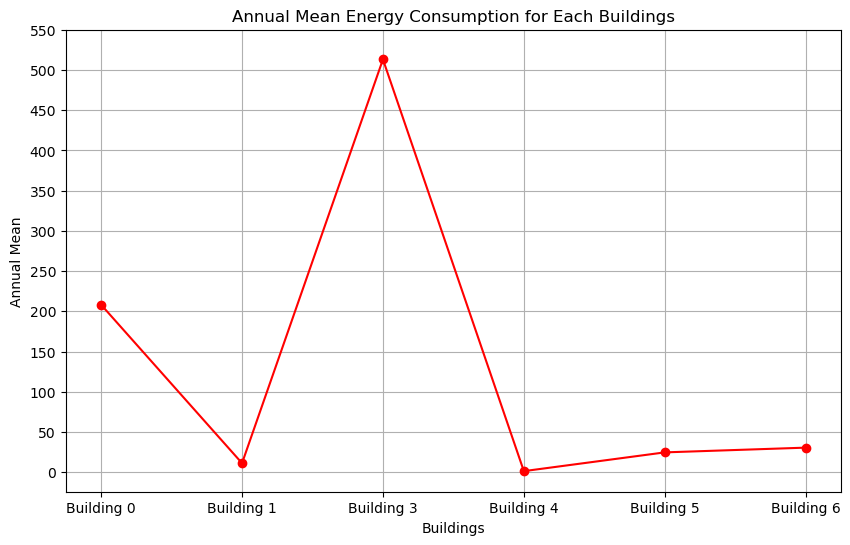

In [199]:
# Define the 6 numeric values
values = [annual_mean_building_0_mean, annual_mean_building_1_mean, annual_mean_building_3_mean, annual_mean_building_4_mean, annual_mean_building_5_mean,annual_mean_building_6_mean]

# Define the corresponding labels for these values (e.g., names of the buildings)
labels = ['Building 0', 'Building 1', 'Building 3', 'Building 4', 'Building 5', 'Building 6']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(labels, values, marker='o', linestyle='-', color='red')

# Add labels and title
plt.xlabel('Buildings')
plt.ylabel('Annual Mean')
plt.title('Annual Mean Energy Consumption for Each Buildings')
plt.grid(True)
# Set y-axis ticks to increase by 50
max_value = max(values)
plt.yticks(range(0, int(max_value) + 50, 50))

# Show the plot
plt.show()

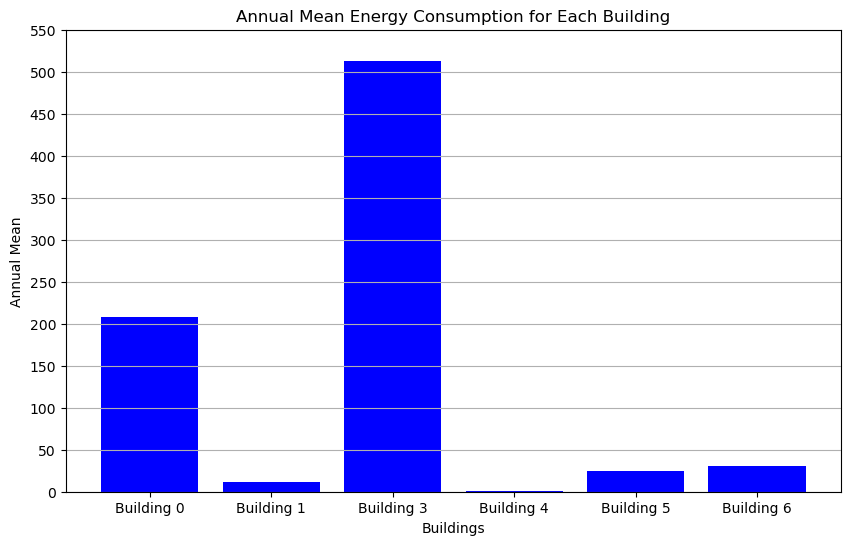

In [200]:
import matplotlib.pyplot as plt

# Define the 6 numeric values
values = [annual_mean_building_0_mean, annual_mean_building_1_mean, annual_mean_building_3_mean, annual_mean_building_4_mean, annual_mean_building_5_mean, annual_mean_building_6_mean]

# Define the corresponding labels for these values (e.g., names of the buildings)
labels = ['Building 0', 'Building 1', 'Building 3', 'Building 4', 'Building 5', 'Building 6']

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='blue')

# Add labels and title
plt.xlabel('Buildings')
plt.ylabel('Annual Mean')
plt.title('Annual Mean Energy Consumption for Each Building')
plt.grid(True, axis='y')

# Set y-axis ticks to increase by 50
max_value = max(values)
plt.yticks(range(0, int(max_value) + 50, 50))

# Show the plot
plt.show()


In [201]:
# Resample the data to hourly frequency, using the mean for aggregation
building0data_predict = building0data.resample('H').mean()
building0data_predict = building0data_predict.fillna(0)
# Display the resampled data
building0data_predict


,Building 0
datetime,
2018-04-03 21:00:00,306.500
2018-04-03 22:00:00,274.250
2018-04-03 23:00:00,222.250
2018-04-04 00:00:00,158.250
2018-04-04 01:00:00,121.625
...,...
2020-11-30 19:00:00,202.975
2020-11-30 20:00:00,215.250
2020-11-30 21:00:00,194.275


In [59]:
building0data_predict.isna().sum()

Building 0    0
dtype: int64

In [202]:
# Resample the data to hourly frequency, using the mean for aggregation
building1data_predict = building1data.resample('H').mean()
building1data_predict = building1data_predict.fillna(0)
# Display the resampled data
building1data_predict


,Building 1
datetime,
2019-01-09 23:00:00,15.533333
2019-01-10 00:00:00,20.500000
2019-01-10 01:00:00,20.800000
2019-01-10 02:00:00,20.225000
2019-01-10 03:00:00,22.750000
...,...
2020-11-30 19:00:00,12.150000
2020-11-30 20:00:00,13.700000
2020-11-30 21:00:00,14.800000


In [203]:
# Resample the data to hourly frequency, using the mean for aggregation
building3data_predict = building3data['Building 3'].resample('H').mean()
building3data_predict = building3data_predict.fillna(0)
# Display the resampled data
building3data_predict = building3data_predict


datetime
2016-07-03 21:00:00    581.00
2016-07-03 22:00:00    613.25
2016-07-03 23:00:00    707.25
2016-07-04 00:00:00    763.50
2016-07-04 01:00:00    802.25
                        ...  
2020-11-30 19:00:00    291.00
2020-11-30 20:00:00    397.75
2020-11-30 21:00:00    465.00
2020-11-30 22:00:00    534.50
2020-11-30 23:00:00    659.00
Freq: H, Name: Building 3, Length: 38667, dtype: float64

In [241]:
# Resample the data to hourly frequency, using the mean for aggregation
building3data_predict = building3data['Building 3'].resample('H').mean()

# Fill NA values with 0
building3data_predict = building3data_predict.fillna(0)

# Convert the series back to a dataframe
building3data_predict_df = building3data_predict.reset_index()

# Display the dataframe
building3data_predict_df


,datetime,Building 3
0,2016-07-03 21:00:00,581.00
1,2016-07-03 22:00:00,613.25
2,2016-07-03 23:00:00,707.25
3,2016-07-04 00:00:00,763.50
4,2016-07-04 01:00:00,802.25
...,...,...
38662,2020-11-30 19:00:00,291.00
38663,2020-11-30 20:00:00,397.75
38664,2020-11-30 21:00:00,465.00
38665,2020-11-30 22:00:00,534.50


In [242]:
print(building3data_predict_df.columns)

Index(['datetime', 'Building 3'], dtype='object')


In [204]:
# Resample the data to hourly frequency, using the mean for aggregation
building4data_predict = building4data.resample('H').mean()
building4data_predict = building4data_predict.fillna(0)
# Display the resampled data
building4data_predict


,Building 4
datetime,
2019-07-03 04:00:00,2.00
2019-07-03 05:00:00,1.50
2019-07-03 06:00:00,2.00
2019-07-03 07:00:00,1.00
2019-07-03 08:00:00,1.00
...,...
2020-11-30 19:00:00,1.00
2020-11-30 20:00:00,1.25
2020-11-30 21:00:00,1.75


In [205]:
# Resample the data to hourly frequency, using the mean for aggregation
building5data_predict = building5data.resample('H').mean()
building5data_predict = building5data_predict.fillna(0)
# Display the resampled data
building5data_predict


,Building 5
datetime,
2019-07-25 23:00:00,29.75
2019-07-26 00:00:00,30.00
2019-07-26 01:00:00,29.75
2019-07-26 02:00:00,30.25
2019-07-26 03:00:00,28.75
...,...
2020-11-30 19:00:00,26.00
2020-11-30 20:00:00,27.00
2020-11-30 21:00:00,27.00


In [206]:
building5data_predict.isna().sum()

Building 5    0
dtype: int64

In [207]:
# Resample the data to hourly frequency, using the mean for aggregation
building6data_predict = building6data.resample('H').mean()
building6data_predict = building6data_predict.fillna(0)
# Display the resampled data
building6data_predict


,Building 6
datetime,
2019-07-25 01:00:00,36.8
2019-07-25 02:00:00,35.4
2019-07-25 03:00:00,35.5
2019-07-25 04:00:00,36.0
2019-07-25 05:00:00,35.2
...,...
2020-11-30 19:00:00,26.6
2020-11-30 20:00:00,32.0
2020-11-30 21:00:00,39.3


In [208]:
import pandas as pd

# Assuming building0data DataFrame is already defined as in the provided code
# Specific day to remove
specific_day_to_remove = '2018-07-03'

# Ensure 'datetime 1' is in datetime format
building0data['datetime 1'] = pd.to_datetime(building0data['datetime 1'])

# Filter the DataFrame to exclude the specific day
building0data = building0data[building0data['datetime 1'].dt.date != pd.to_datetime(specific_day_to_remove).date()]

# Display the updated DataFrame
building0data


,datetime 1,Building 0
datetime,,
2018-04-03 21:30:00,2018-04-03 21:30:00,306.5
2018-04-03 21:45:00,2018-04-03 21:45:00,306.5
2018-04-03 22:00:00,2018-04-03 22:00:00,306.5
2018-04-03 22:15:00,2018-04-03 22:15:00,263.5
2018-04-03 22:30:00,2018-04-03 22:30:00,263.5
...,...,...
2020-11-30 22:45:00,2020-11-30 22:45:00,218.6
2020-11-30 23:00:00,2020-11-30 23:00:00,218.6
2020-11-30 23:15:00,2020-11-30 23:15:00,207.2


In [209]:
import pandas as pd

# Assuming building0data DataFrame is already defined as in the provided code
# Specific value to find in 'Building 0'
specific_value = 0

# Filter the DataFrame to find the specific value in 'Building 0'
find_data = building3data[building3data['Building 3'] == specific_value]

# Display the filtered rows
find_data


,datetime 1,Building 3
datetime,,


# SVM

# polynomial regression model

# Random Forests

In [112]:
new_data1

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building 6,month,hour
datetime,,,,,,,,,,,,,,,
2019-07-26 00:00:00,2019-07-26 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,11.57,8.06,4.88,0.79,125.23,329.70,0.99,37.5,7,0
2019-07-26 01:00:00,2019-07-26 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,11.74,8.37,4.49,0.80,225.86,326.13,0.87,37.4,7,1
2019-07-26 02:00:00,2019-07-26 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.30,8.70,3.82,0.79,225.36,335.45,0.90,36.2,7,2
2019-07-26 03:00:00,2019-07-26 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.46,9.23,2.84,0.81,202.20,343.44,1.00,34.7,7,3
2019-07-26 04:00:00,2019-07-26 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.58,9.35,1.99,0.81,194.53,349.33,1.00,33.7,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,2020-11-30 19:00:00,"(-37.91, 145.13)",era5,69.59,10.0,20.39,12.65,5.38,0.61,0.17,345.16,0.51,26.6,11,19
2020-11-30 20:00:00,2020-11-30 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,21.29,13.14,6.06,0.60,57.54,340.41,0.88,32.0,11,20
2020-11-30 21:00:00,2020-11-30 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,22.12,13.44,6.24,0.58,219.35,338.43,1.00,39.3,11,21


In [111]:
X = new_data1[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
y = new_data1['Building 6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lower_model = RandomForestRegressor(n_estimators = 100)
lower_model.fit(X_train, y_train)

predictions = upper_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, predictions)
print("R^2 Score:", r2)

correlation_matrix = new_data1.corr()
print(correlation_matrix['Building 6'].abs().sort_values(ascending=False))
# Get feature importances
feature_importances = lower_model.feature_importances_
print(feature_importances)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# print(feature_importance_df)re

Mean Squared Error: 232734.43685845425
R^2 Score: -3334.9952997037035
Building 6                           1.000000
surface_solar_radiation (W/m^2)      0.301493
temperature (degC)                   0.235414
hour                                 0.217201
relative_humidity ((0-1))            0.211357
surface_thermal_radiation (W/m^2)    0.152093
month                                0.148008
dewpoint_temperature (degC)          0.124468
wind_speed (m/s)                     0.082238
total_cloud_cover (0-1)              0.037721
model elevation (surface)                 NaN
utc_offset (hrs)                          NaN
Name: Building 6, dtype: float64
[0.05725786 0.16478372 0.15809327 0.13830709 0.2097965  0.16174091
 0.11002065]


In [113]:
start_date = '2020-12-01 :00:00'
end_date = '2020-12-07 23:00:00'
lower_data = data.loc[start_date:end_date]
lower_data['month'] = lower_data.index.month
lower_data['hour'] = lower_data.index.hour
for_model = lower_data[['hour','month', 'temperature (degC)', 'surface_thermal_radiation (W/m^2)', 'surface_solar_radiation (W/m^2)', 'wind_speed (m/s)','relative_humidity ((0-1))']]
october_predictions = lower_model.predict(for_model)
date_range = pd.date_range(start = start_date, end = end_date, freq = 'H')
oct_week_1s = pd.DataFrame({'Building 6 predictions':october_predictions}, index = date_range)

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [2020-12-01 :00:00] of type str